# SPICEnet: Classification of images of electrical components

*Kristóf Kónya, Jakob Tschavoll*

## Setup

In [1]:
# file related
import os
from os.path import join
import shutil

# image manipulation
from PIL import Image, ImageChops, ImageDraw, ImageFont

# machine learning
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import load_model
import tensorflow as tf
from sklearn.model_selection import train_test_split

# utils
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import random

print(f"TF version {tf.__version__}")

2023-12-08 15:25:12.323038: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


TF version 2.11.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if(gpus):
    try:
        for gpu in gpus:            
            tf.config.experimental.set_memory_growth(gpu,True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
gpus

1 Physical GPUs, 1 Logical GPUs


2023-12-08 15:25:27.045615: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-08 15:25:27.133104: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-08 15:25:27.133636: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-08 15:25:27.144824: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data

### SPICEnet parameters
Data generation and training parameters are all accessible through the below listed dictionary `SPICENET_PARAMS`. The keys are used like this:

- `src_path`: path to the base images relative to the project's root data_dir. Only few are needed, the rest will be created from the source image's augmentations.
- `dataset_path`: path to the dataset relative to the project's root data_dir. This folder **does not need to exist yet**, but you can decide how it is named.
- `resize`: amount of pixels to which input images will be resized (height and width are the same)
- `offset_x`: distance and iterations with which the images will be shifted around for data augmentation. A python `range()` object is expected here. For example, a given `range(-150, 150, 30)` will offset a source image as many times as 30 pixels will fit into a range of 150 to the left and 150 to the right, meaning a total of 300 pixels. Since each step is 30 pixels, this range will produce 10 new images.
- `offset_y`: same as `offset_x` but vertical.
- `rotation`: rotational equivalent of `offset_x/y`. A given `range(0, 180, 2)` will rotate the image from 0 to 180 degrees in 2 degree steps, equating a total of 90 new images.
- `zoom`: scaling equivalent of `offset_x/y`. A given `range(100, 300, 20)` will zoom into the image from 100% to 300% in 20% steps creating a total of 10 new images.
- `letter_noise_n`: amount of artificially added letters for classes "Corner", "Junction" and "Cross" for network robustness.
- `contrast_tresh`: `uint8_t` black and white pixel scaling at which point a pixel will be either shifted to 255 (black) or 0 (white).
- `train_test_ratio`: ratio between the sizes of the train and test data splits, e.g. 0.2 (20%) means that 20% of the whole dataset are used for testing and 80% for training.
- `only_train_test_split`: If this is set to `True`, the unsplit dataset will be temporary and removed after the splitting process is done. What will remain is only the train-test split and the source images.
- `batches`: amount of batches for the all sets
- `epochs`: number of training epochs (a low number is recommended, since the base model is already pretty competent (vgg16)).
- `class_list`: python `list` with readable names of classes. In the dataset, their **intuitive** (not syntactical, e.g. first index is `1`, not `0`) indexes are used instead, e.g. `1` is `"Resistor"`.

In [3]:
SPICENET_PARAMS = dict({
    "src_path": "img_src",
    "dataset_path": "dataset",
    "resize": 224,
    "offset_x": range(-30, 30, 5),
    "offset_y": range(-30, 30, 5),
    "rotation": range(0, 180, 90),
    "zoom": range(100, 110, 1),
    "letter_noise_n": 1,
    "contrast_thresh": 170,
    "train_test_ratio": 0.2,
    "only_train_test_split": True,
    "batches": 20,
    "epochs": 2,
    "class_list": ["Resistor",
                   "Capacitor",
                   "Inductor",
                   "Diode",
                   "Corner",
                   "Junction",
                   "Cross",
                   "GND"]
})

### Data generation

In [4]:
def create_dataset_from_original(reference_image_path: str, output_path: str):
    reference_image = Image.open(reference_image_path)
    i = 2
    reference_image = add_letter_noise(reference_image, amount=SPICENET_PARAMS["letter_noise_n"])
    for offset_value_x in SPICENET_PARAMS["offset_x"]:
        for offset_value_y in SPICENET_PARAMS["offset_y"]:
            offset_img = ImageChops.offset(reference_image, offset_value_x, offset_value_y)
            fn = lambda x : 255 if x > SPICENET_PARAMS["contrast_thresh"] else 0
            offset_img = offset_img.convert('L').point(fn, mode='1')
            for rot_value in SPICENET_PARAMS["rotation"]:
                new_img = offset_img.rotate(-rot_value)
                for zoom_value in SPICENET_PARAMS["zoom"]:
                    new_img = scale_image(new_img, (0.5, 0.5), zoom_value/100)
                    new_img.save(output_path + str(i) + ".png", "PNG")
                    i += 1

def add_letter_noise(img: Image, amount=1):
    components = ['R', 'R1', 'R2', 'R3', 'C', 'C1', 'C2', 'C3', 'L', 'L1', 'L2', 'L3']
    font_size = 30
    font = ImageFont.truetype("arial.ttf", font_size)
    draw = ImageDraw.Draw(img)

    for _ in range(amount):
        component = random.choice(components)
        x = random.randint(0, img.width - font_size)
        y = random.randint(0, img.height - font_size)
        color = (0, 0, 0)
        draw.text((x, y), component, font=font, fill=color)

    return img

def scale_image(img: Image, xy, scale_factor):
    center = (img.size[0] * xy[0], img.size[1] * xy[1])
    new_size = (img.size[0] / scale_factor, img.size[1] / scale_factor)
    left = max (0, (int) (center[0] - new_size[0] / 2))
    right = min (img.size[0], (int) (center[0] + new_size[0] / 2))
    upper = max (0, (int) (center[1] - new_size[1] / 2))
    lower = min (img.size[1], (int) (center[1] + new_size[1] / 2))
    cropped_img = img.crop((left, upper, right, lower))
    return cropped_img

def train_valid_dataset(dataset_path, train_path, test_path):
    symbols = os.listdir(dataset_path)
    symbols.sort()
    splits = train_test_split(symbols, test_size=SPICENET_PARAMS["train_test_ratio"])
    dest_paths = [train_path, test_path]

    for split, dest_path in zip(splits, dest_paths):
        src_data = [dataset_path+'/{}'.format(image) for image in split]
        dest_data = [dest_path+'/{}'.format(image) for image in split]
        for i in range(len(src_data)):
            shutil.copy(src_data[i], dest_data[i])


In [5]:
if SPICENET_PARAMS["only_train_test_split"]:
    data_dir = "./temp"
else:
    data_dir = "./raw_dataset"

if os.access(data_dir, os.F_OK) == True:
    shutil.rmtree(data_dir) # doesnt work

os.mkdir(data_dir)
parts = [p for p in os.listdir(SPICENET_PARAMS["src_path"]) if p.endswith((".png", ".PNG", 
                                                                           ".jpg", ".jpeg", 
                                                                           ".JPG", ".JPEG"))]
for part in parts:
    part_path = join(data_dir, part[0])
    if not os.path.exists(part_path):
        os.mkdir(part_path)
    output_path = join(part_path, os.path.splitext(part)[0] + "_")
    reference_image_path = join(SPICENET_PARAMS["src_path"], part)
    print(f"Creating '{(SPICENET_PARAMS['class_list'])[int(part[0])-1]}' symbols...")
    create_dataset_from_original(reference_image_path, output_path)

dataset_path = SPICENET_PARAMS["dataset_path"]
if os.access(dataset_path, os.F_OK) == True:
    shutil.rmtree(dataset_path)

os.mkdir(dataset_path)
os.mkdir(join(dataset_path, "train"))
os.mkdir(join(dataset_path, "test"))

print("Creating dataset directory...")
for part in parts:
    part_train_path = join(dataset_path, "train", part[0])
    part_test_path = join(dataset_path, "test", part[0])
    if not os.path.exists(part_train_path):
        os.mkdir(part_train_path)
    if not os.path.exists(part_test_path):
        os.mkdir(part_test_path)
    part_path = join(data_dir, part[0])
    train_valid_dataset(dataset_path=part_path,
                        train_path=part_train_path,
                        test_path=part_test_path)

shutil.copytree('./validation', dataset_path+'/valid')
if SPICENET_PARAMS["only_train_test_split"]:
    shutil.rmtree(data_dir)
print("Done.")

Creating 'Diode' symbols...
Creating 'Resistor' symbols...
Creating 'Resistor' symbols...
Creating 'Resistor' symbols...
Creating 'Resistor' symbols...
Creating 'Resistor' symbols...
Creating 'Capacitor' symbols...
Creating 'Capacitor' symbols...
Creating 'Capacitor' symbols...
Creating 'Capacitor' symbols...
Creating 'Capacitor' symbols...
Creating 'Inductor' symbols...
Creating 'Inductor' symbols...
Creating 'Inductor' symbols...
Creating 'Inductor' symbols...
Creating 'Inductor' symbols...
Creating 'Diode' symbols...
Creating 'Diode' symbols...
Creating 'Diode' symbols...
Creating 'Diode' symbols...
Creating 'Corner' symbols...
Creating 'Corner' symbols...
Creating 'Corner' symbols...
Creating 'Corner' symbols...
Creating 'Corner' symbols...
Creating 'Corner' symbols...
Creating 'Corner' symbols...
Creating 'Junction' symbols...
Creating 'Junction' symbols...
Creating 'Junction' symbols...
Creating 'Junction' symbols...
Creating 'Junction' symbols...
Creating 'Junction' symbols...
C

### Data sighting

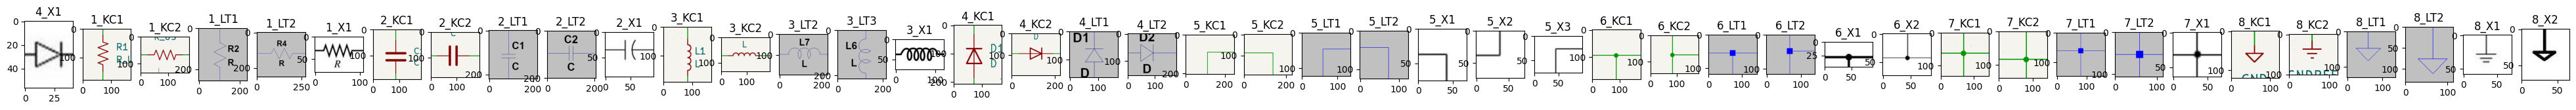

In [6]:
parts = os.listdir(SPICENET_PARAMS["src_path"])
SPICENET_PARAMS["num_classes"] = len(SPICENET_PARAMS["class_list"])
fig, axs = plt.subplots(nrows=1, ncols=len(parts), figsize=(50, 50))

for i, part in enumerate(parts):
    part_symbol = plt.imread(join(SPICENET_PARAMS["src_path"], part))
    axs[i].imshow(part_symbol)
    axs[i].title.set_text(os.path.splitext(part)[0])

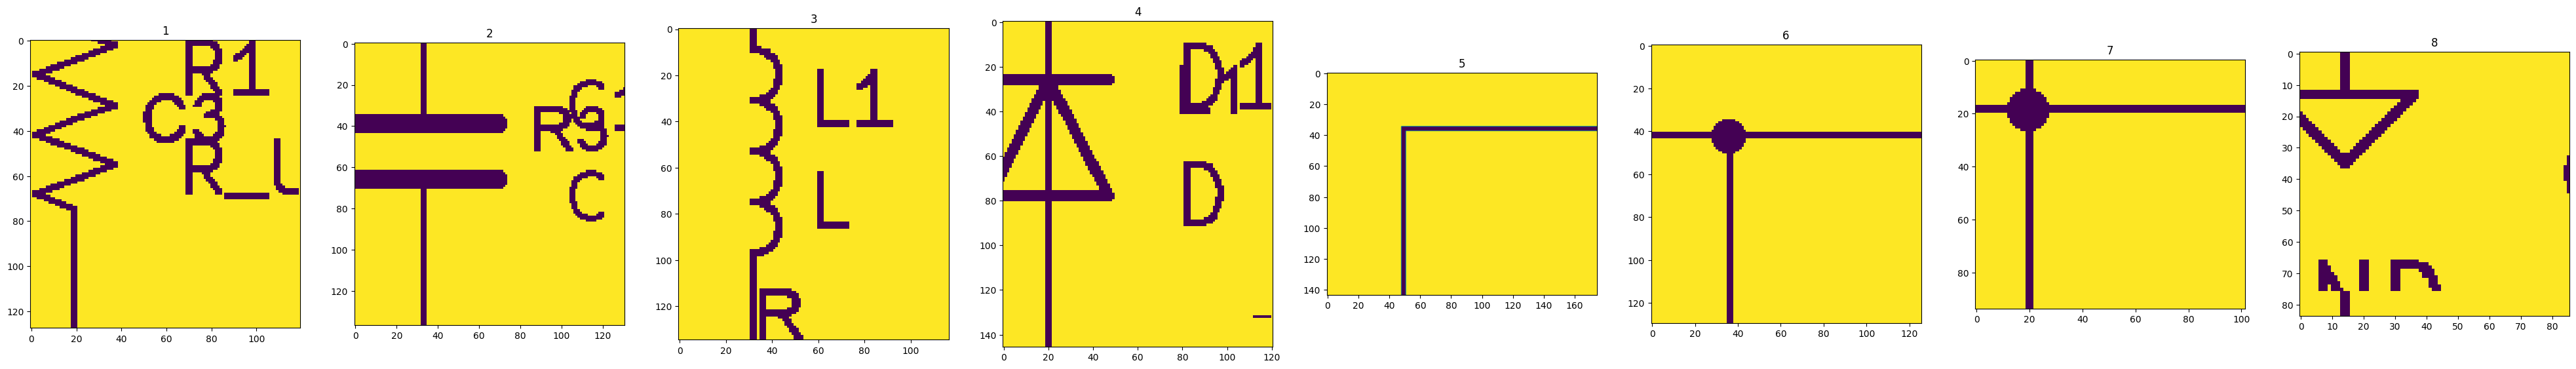

In [7]:
path = join(SPICENET_PARAMS["dataset_path"], "train")
parts = [p for p in os.listdir(path) if os.path.isdir(join(path, p))]
fig, axs = plt.subplots(nrows=1, ncols=len(parts), figsize=(50, 50))

for i, part in enumerate(parts):
    part_path = join(path, part, os.listdir(join(path, part))[0])
    part_img = plt.imread(part_path)
    axs[i].imshow(part_img)
    axs[i].title.set_text(part)

### Training

In [8]:
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

In [9]:
train_generator = data_generator.flow_from_directory(
    join(SPICENET_PARAMS["dataset_path"], "train"),
    target_size=(SPICENET_PARAMS["resize"], SPICENET_PARAMS["resize"]),
    batch_size=SPICENET_PARAMS["batches"],
    class_mode='categorical')

Found 126679 images belonging to 8 classes.


In [10]:
test_generator = data_generator.flow_from_directory(
    join(SPICENET_PARAMS["dataset_path"], "test"),
    target_size=(SPICENET_PARAMS["resize"], SPICENET_PARAMS["resize"]),
    batch_size=SPICENET_PARAMS["batches"],
    class_mode='categorical')

Found 89852 images belonging to 8 classes.


In [11]:
vgg16_model = Sequential()

In [12]:
vgg16_model.add(VGG16(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    ))

In [13]:
vgg16_model.add(Dense(SPICENET_PARAMS["num_classes"], activation='softmax'))
vgg16_model.layers[0].trainable = False
vgg16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 8)                 4104      
                                                                 
Total params: 14,718,792
Trainable params: 4,104
Non-trainable params: 14,714,688
_________________________________________________________________


In [14]:
vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
steps_per_epoch_training = len(train_generator)
steps_per_epoch_test = len(test_generator) 

In [16]:
fit_history = vgg16_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=SPICENET_PARAMS["epochs"],
    validation_data=test_generator,
    validation_steps=steps_per_epoch_test,
    validation_batch_size=SPICENET_PARAMS["batches"],
    verbose=1,
)
vgg16_model.save(f'SPICEnet.h5')

Epoch 1/2


2023-12-08 15:40:12.936822: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2023-12-08 15:40:13.987939: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-12-08 15:40:15.498019: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1cb86a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-08 15:40:15.498069: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2023-12-08 15:40:15.656022: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECT

6334/6334 [==============================] - 973s 153ms/step - loss: 0.0864 - accuracy: 0.9766 - val_loss: 0.0185 - val_accuracy: 0.9944
Epoch 2/2
6334/6334 [==============================] - 993s 157ms/step - loss: 0.0135 - accuracy: 0.9958 - val_loss: 0.0125 - val_accuracy: 0.9961


In [17]:
def autopush_model(commit_msg):
    os.system('git add SPICEnet.h5')
    os.system(f'git commit -m "autopush SPICEnet: {commit_msg}"')
    os.system("git push origin")

autopush_model(datetime.now().strftime("%m/%d/%Y, %H:%M:%S"))

[main 89aab48] autopush SPICEnet: 12/08/2023, 16:12:57
 1 file changed, 0 insertions(+), 0 deletions(-)


remote: warning: See https://gh.io/lfs for more information.        
remote: warning: File SPICEnet.h5 is 56.24 MB; this is larger than GitHub's recommended maximum file size of 50.00 MB        
remote: warning: GH001: Large files detected. You may want to try Git Large File Storage - https://git-lfs.github.com.        
To github.com:jake-is-ESD-protected/SPICEnet.git
   957a4e1..89aab48  main -> main


### Evaluation

In [18]:
evaluate_generator = data_generator.flow_from_directory(
    join(SPICENET_PARAMS["dataset_path"], "valid"),
    target_size=(SPICENET_PARAMS["resize"], SPICENET_PARAMS["resize"]),
    shuffle=False)

Found 8 images belonging to 8 classes.


In [19]:
vgg16_evaluate_history = vgg16_model.evaluate(
    evaluate_generator,
    verbose=1,
)

1/1 [==============================] - 1s 977ms/step - loss: 6.4550e-05 - accuracy: 1.0000


In [20]:
print("VGG16 Accuracy:", vgg16_evaluate_history[1])

VGG16 Accuracy: 1.0


1/1 [==============================] - 0s 325ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


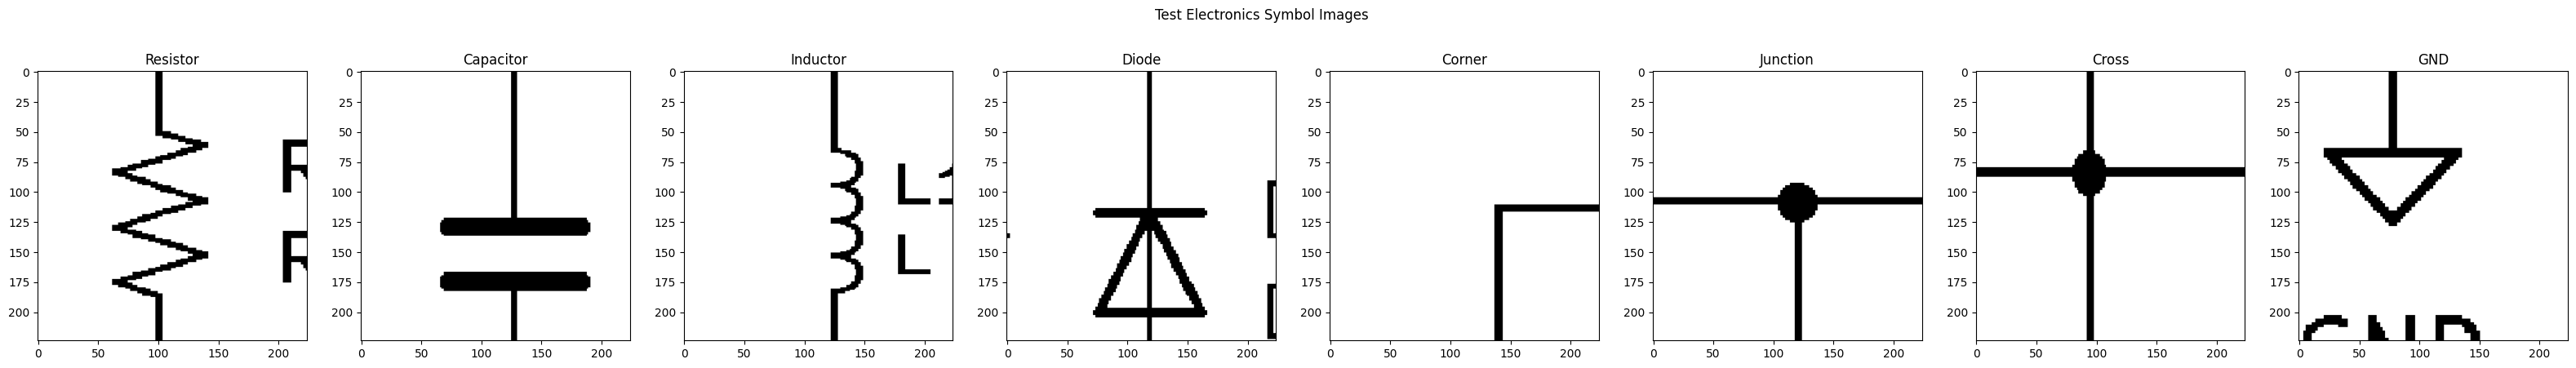

In [21]:
vgg16_predict = vgg16_model.predict(
    evaluate_generator
)
vgg16_predict

result_index = [SPICENET_PARAMS["class_list"][s] for s in np.argmax(vgg16_predict,axis=1)]
result_index

batch = evaluate_generator.next()
batch_images = evaluate_generator.next()[0]

fig, axs = plt.subplots(nrows=1, ncols=len(SPICENET_PARAMS["class_list"]), figsize=(40, 5))
ind = 0
for ax1 in axs:
    image_data = batch_images[ind]
    ax1.imshow(image_data, vmin=0, vmax=255)
    ax1.title.set_text(result_index[ind])
    ind += 1

fig.suptitle('Test Electronics Symbol Images') 
plt.show()